# Check MLA outlier distributions

In [1]:
# !pip install matplotlib scipy

In [2]:
from safetensors import safe_open
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ls mla_ckpts/

layer00/  layer04/  layer08/  layer12/  layer16/  layer20/  layer24/
layer01/  layer05/  layer09/  layer13/  layer17/  layer21/  layer25/
layer02/  layer06/  layer10/  layer14/  layer18/  layer22/  layer26/
layer03/  layer07/  layer11/  layer15/  layer19/  layer23/


In [4]:
# ls mla_ckpts/layer00

In [5]:
use_gpu = False  # run locally
device = 0 if use_gpu else None

records_all_layer = []
for layer_id in range(27):
    records_all_iter = []
    for iter_id in range(0, 140):
        file_name = f"mla_ckpts/layer{layer_id:02}/mla_ckpt_{iter_id:03}.safetensors"
        tensors = {}
        with safe_open(file_name, framework="pt", device=device) as f:
            for k in f.keys():
                tensors[k] = f.get_tensor(k)
        records_all_iter.append(tensors)
    records_all_layer.append(records_all_iter)

## records_all_layer  # too long, do not pring

In [6]:
tensors = records_all_layer[0][2]
for name, tensor in tensors.items():
    print(name, tensor.shape, tensor.dtype, tensor.device, sep=" | ")

kv_cache_used | torch.Size([16, 18, 512]) | torch.bfloat16 | cpu
output_x | torch.Size([16, 1, 16, 512]) | torch.bfloat16 | cpu
pe_cache_used | torch.Size([16, 18, 64]) | torch.bfloat16 | cpu
q_nope | torch.Size([16, 1, 16, 512]) | torch.bfloat16 | cpu
q_pe | torch.Size([16, 1, 16, 64]) | torch.bfloat16 | cpu
scores | torch.Size([16, 1, 16, 18]) | torch.bfloat16 | cpu
softmax_scale | torch.Size([]) | torch.bfloat16 | cpu


In [7]:
def to_numpy(x):
    # numpy has no BFloat16 dtype
    return x.cpu().to(torch.float32).numpy()

def extract_q(all_records, key="q_nope"):
    all_output = []
    for records in all_records:
        temp_output = []
        for record in records:
            data = to_numpy(record[key])
            temp_output.append(data)
            # print(data.shape)
            
        temp_output = np.concatenate(temp_output, axis=1)
        all_output.append(temp_output)
    return np.stack(all_output)

def extract_kv(all_records, key="kv_cache_used"):
    all_output = []
    for records in all_records:
        record = records[-1]  # last iter contains full cache
        data = to_numpy(record[key])
        all_output.append(data)
    return np.stack(all_output)

In [8]:
%%time
q_nope_all = extract_q(records_all_layer)
q_nope_all.shape  # [layer, batch, iter(seq), head, hidden]

CPU times: user 29.4 s, sys: 1.42 s, total: 30.8 s
Wall time: 1.28 s


(27, 16, 155, 16, 512)

In [9]:
kv_cache_all = extract_kv(records_all_layer)
kv_cache_all.shape # [layer, batch, seq(last_iter), head, hidden]

(27, 16, 155, 512)

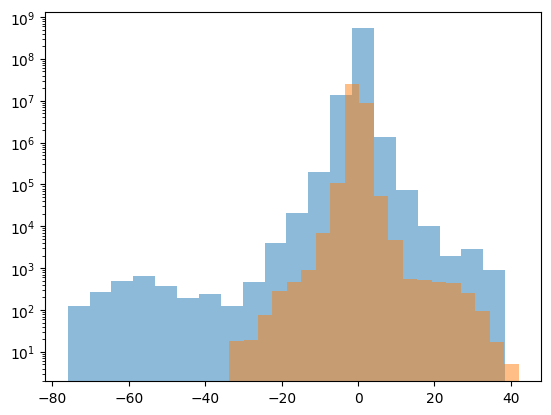

In [10]:
plt.hist(q_nope_all.flatten(), log=True, bins=20, alpha=0.5);
plt.hist(kv_cache_all.flatten(), log=True, bins=20, alpha=0.5);

In [11]:
%%time
x_output_all = extract_q(records_all_layer, key="output_x")  # same shape as q

CPU times: user 39.3 s, sys: 1.53 s, total: 40.8 s
Wall time: 1.77 s


In [12]:
x_output_all.shape

(27, 16, 155, 16, 512)

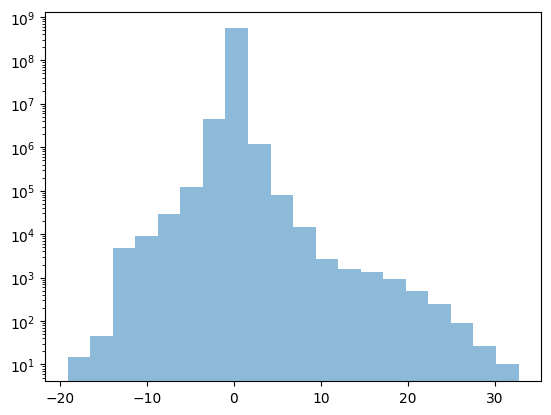

In [13]:
plt.hist(x_output_all.flatten(), log=True, bins=20, alpha=0.5);

## Hadamard

In [14]:
from scipy.linalg import hadamard

K = q_nope_all.shape[-1]
H = hadamard(K, dtype=np.float32) / np.sqrt(K)
H.shape

(512, 512)

In [15]:
%%time
q_nope_all_rotate = q_nope_all @ H
kv_cache_all_rotate = kv_cache_all @ H

CPU times: user 8min 21s, sys: 2.56 s, total: 8min 24s
Wall time: 16.4 s


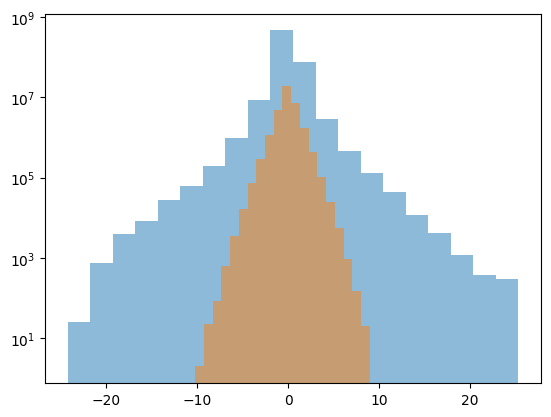

In [16]:
plt.hist(q_nope_all_rotate.flatten(), log=True, bins=20, alpha=0.5);
plt.hist(kv_cache_all_rotate.flatten(), log=True, bins=20, alpha=0.5);

In [17]:
x_output_all_rotate = x_output_all @ H

Text(0.5, 1.0, 'MLA - x_output (ds-v2-lite)')

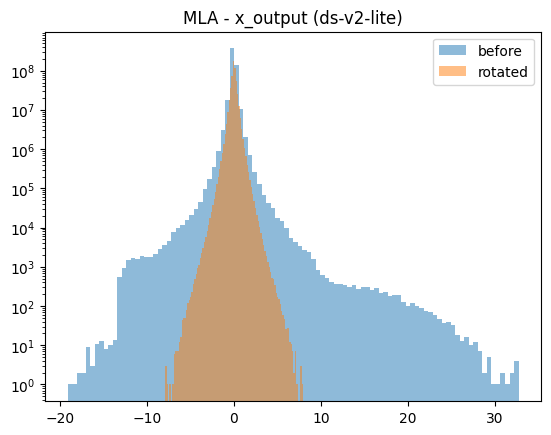

In [18]:
plt.hist(x_output_all.flatten(), log=True, bins=100, alpha=0.5, label="before");
plt.hist(x_output_all_rotate.flatten(), log=True, bins=100, alpha=0.5, label="rotated");
plt.legend()
plt.title("MLA - x_output (ds-v2-lite)")

Text(0.5, 1.0, 'MLA - q_nope (ds-v2-lite)')

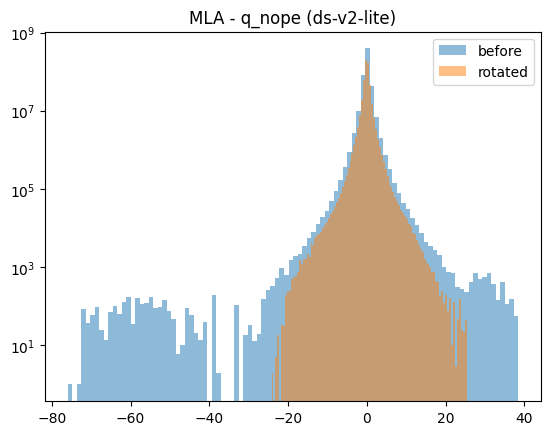

In [19]:
plt.hist(q_nope_all.flatten(), log=True, bins=100, alpha=0.5, label="before");
plt.hist(q_nope_all_rotate.flatten(), log=True, bins=100, alpha=0.5, label="rotated");
plt.legend()
plt.title("MLA - q_nope (ds-v2-lite)")

Text(0.5, 1.0, 'MLA - kv_cache (ds-v2-lite)')

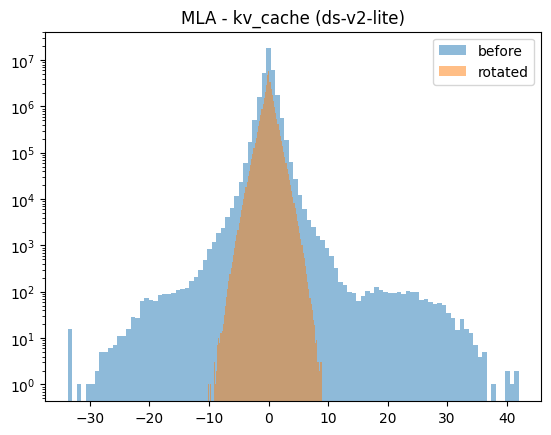

In [20]:
plt.hist(kv_cache_all.flatten(), log=True, bins=100, alpha=0.5, label="before");
plt.hist(kv_cache_all_rotate.flatten(), log=True, bins=100, alpha=0.5, label="rotated");
plt.legend()
plt.title("MLA - kv_cache (ds-v2-lite)")

## Per-layer plot

/tmp/ipykernel_3336/3857349729.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # one figure per layer


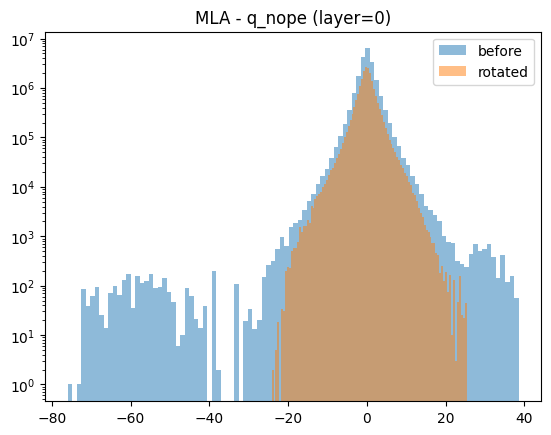

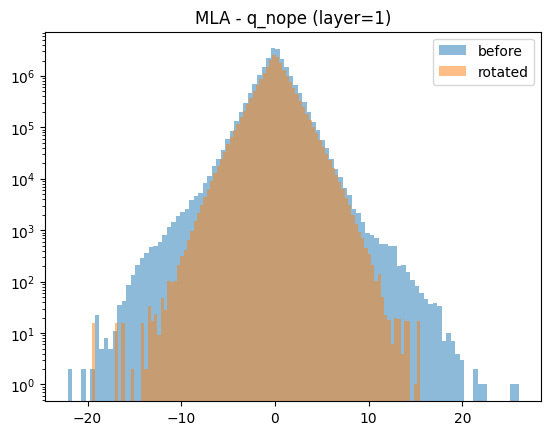

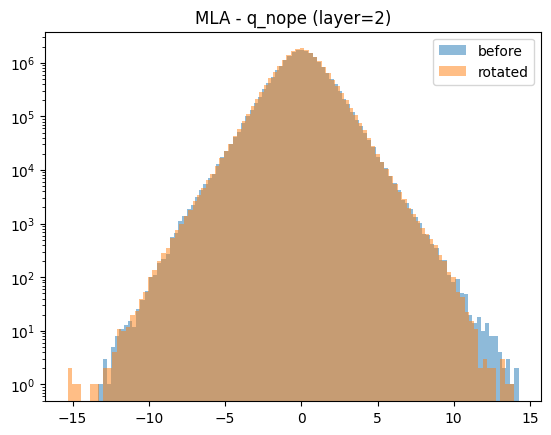

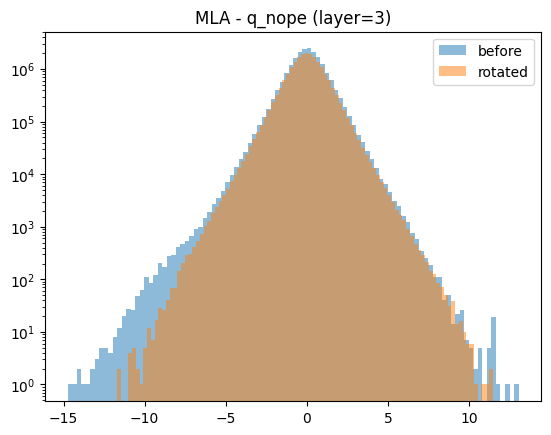

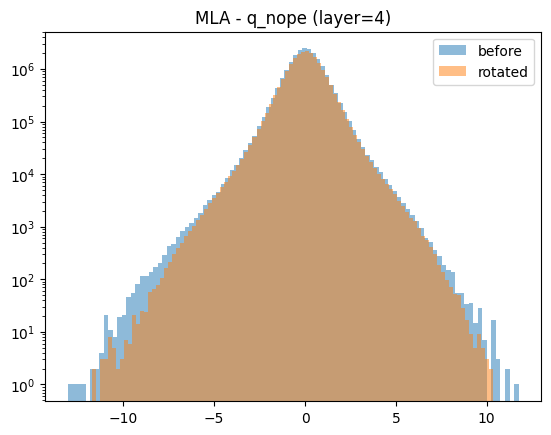

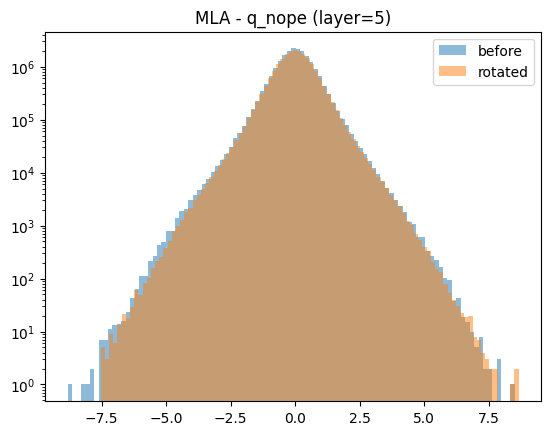

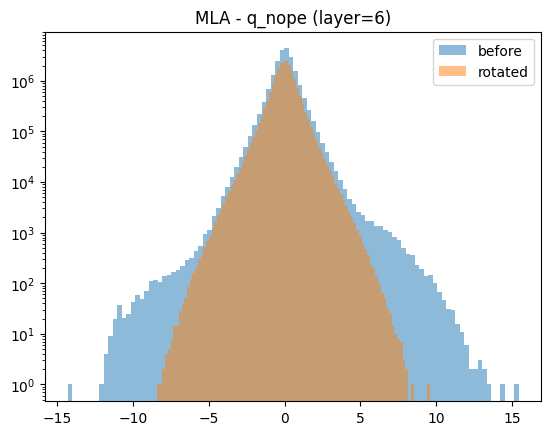

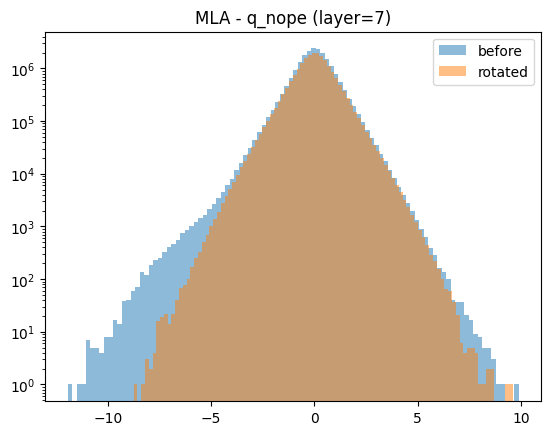

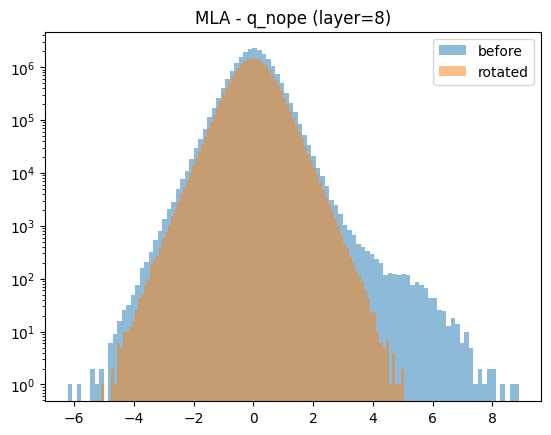

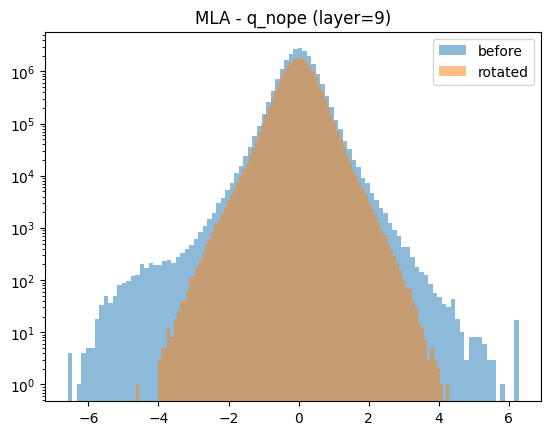

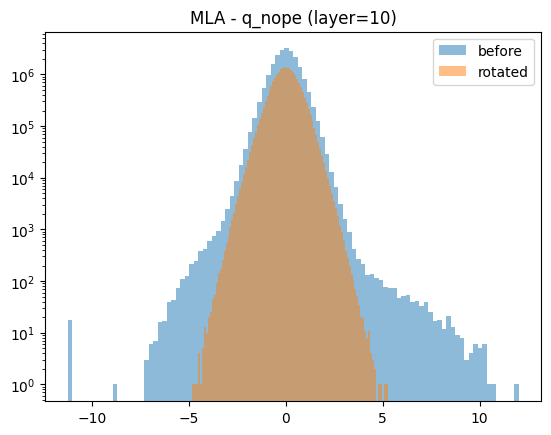

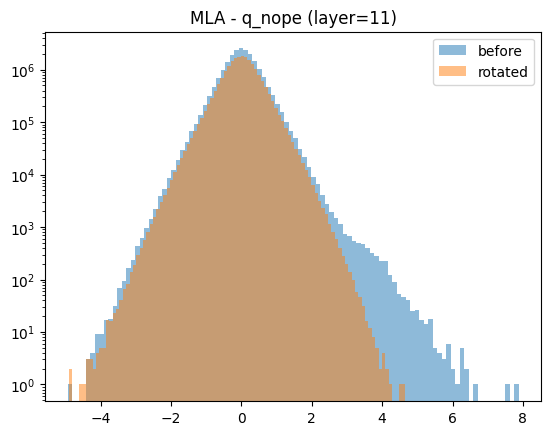

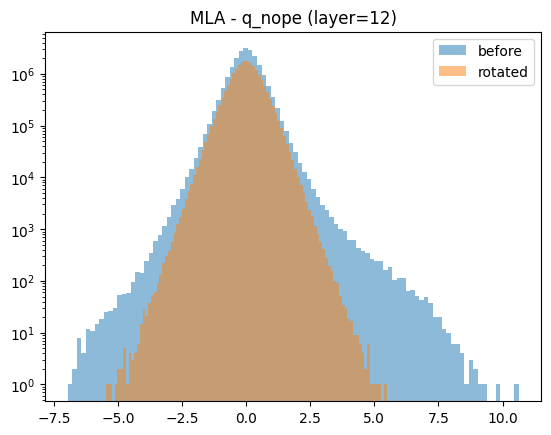

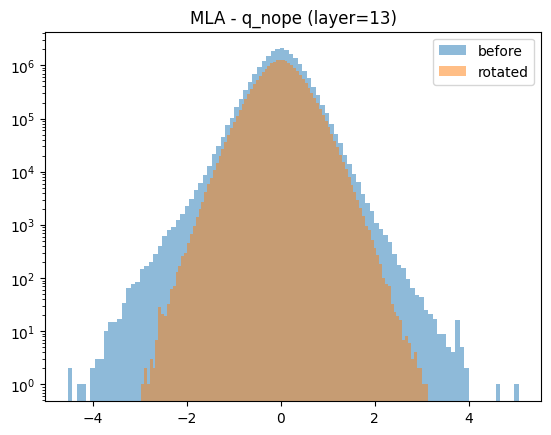

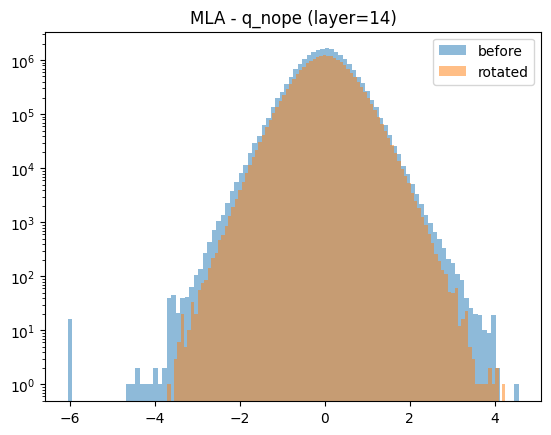

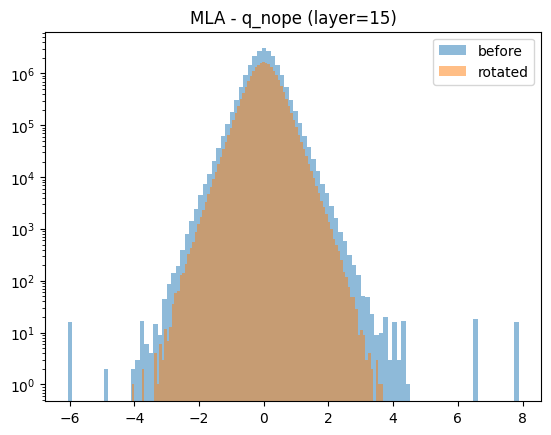

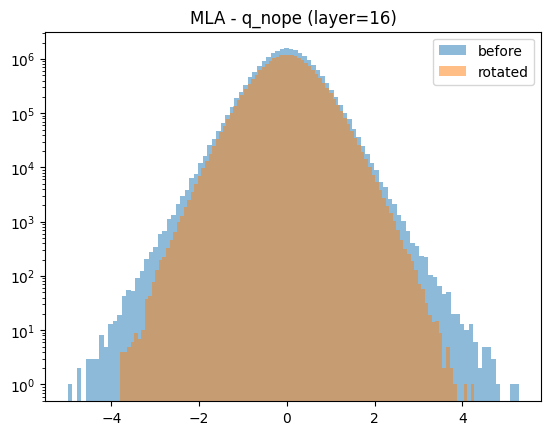

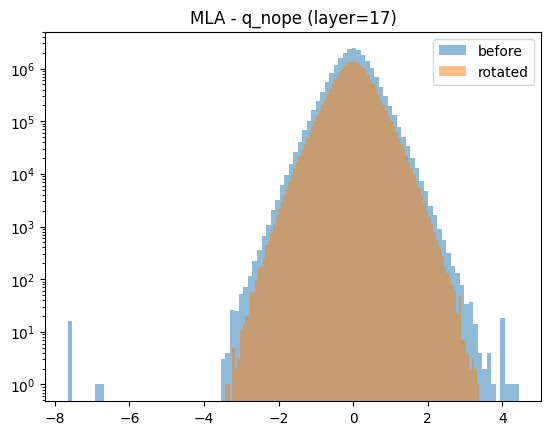

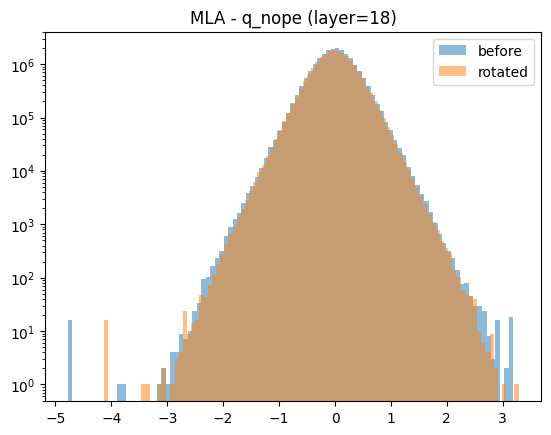

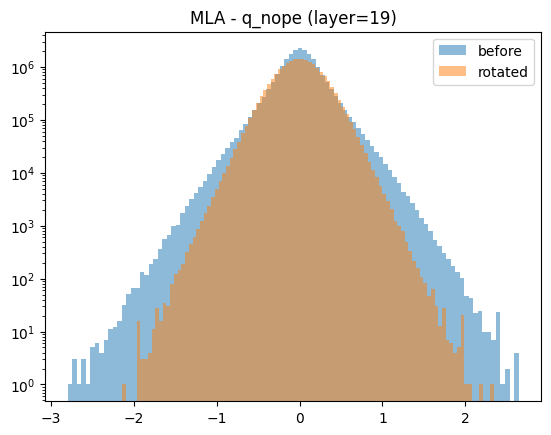

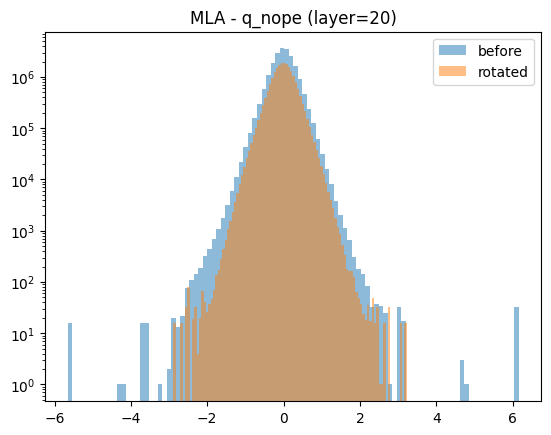

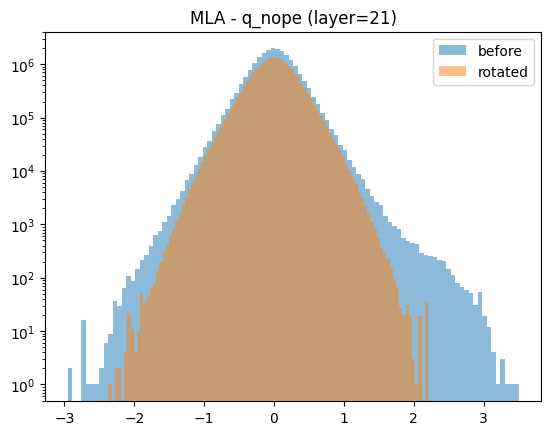

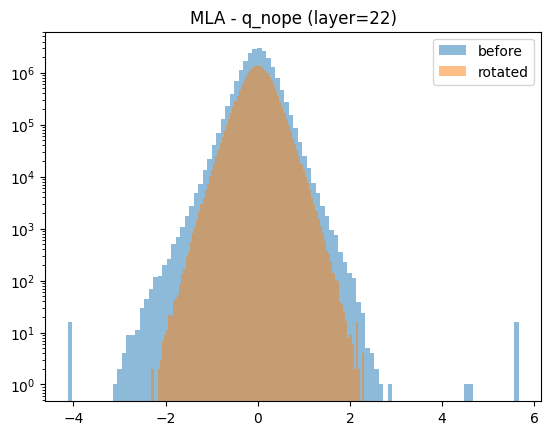

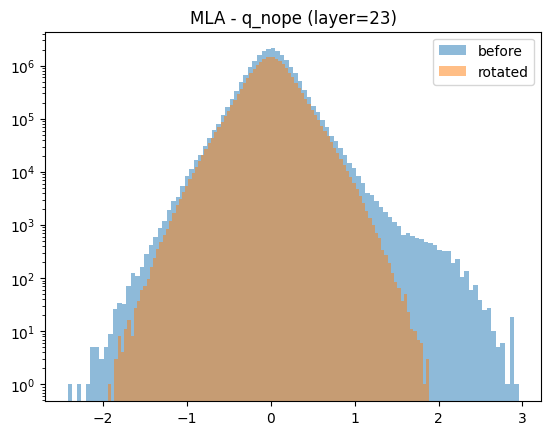

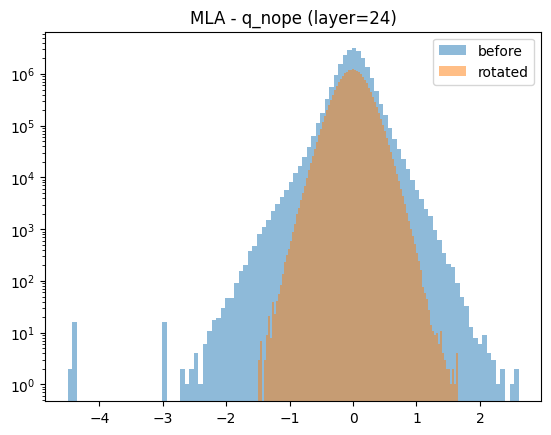

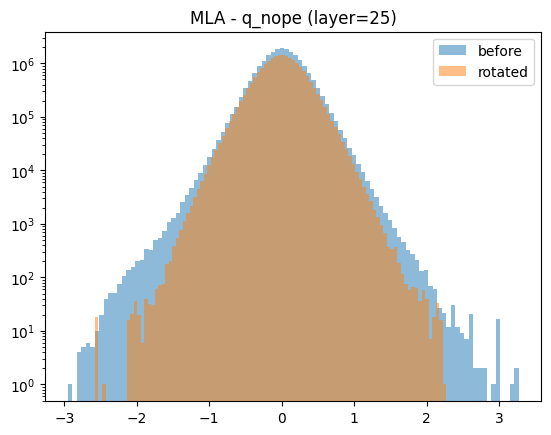

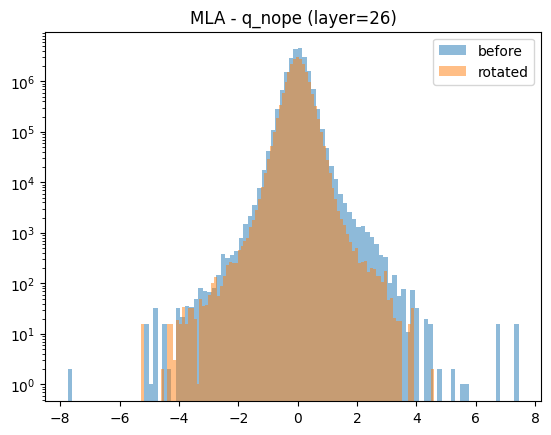

In [22]:
for layer_idx in range(27):  # 27 layers max
    plt.figure()  # one figure per layer
    plt.hist(q_nope_all[layer_idx].flatten(), log=True, bins=100, alpha=0.5, label="before");
    plt.hist(q_nope_all_rotate[layer_idx].flatten(), log=True, bins=100, alpha=0.5, label="rotated");
    plt.legend()
    plt.title(f"MLA - q_nope (layer={layer_idx})")

/tmp/ipykernel_3336/2323883369.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # one figure per layer


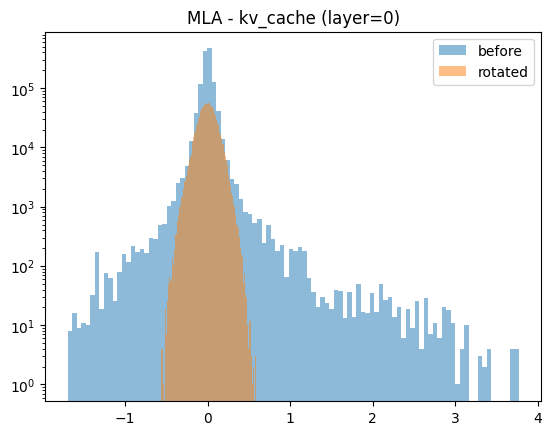

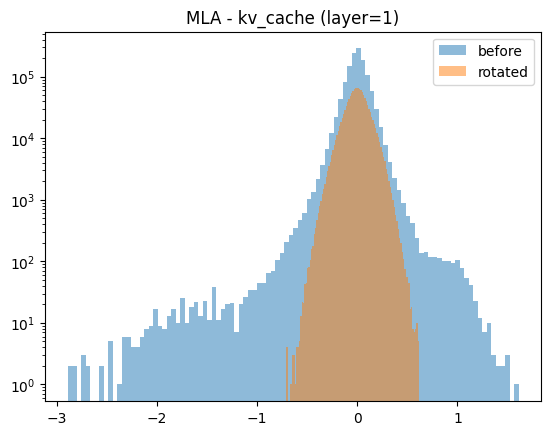

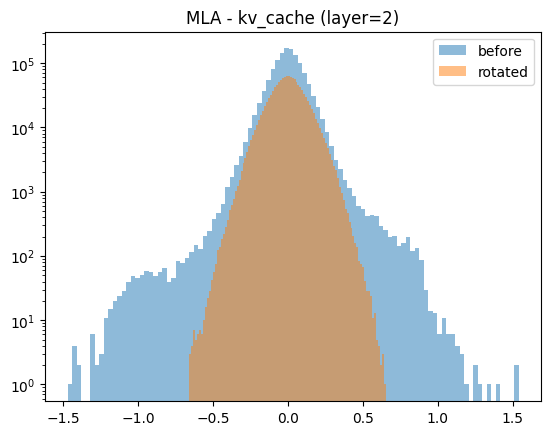

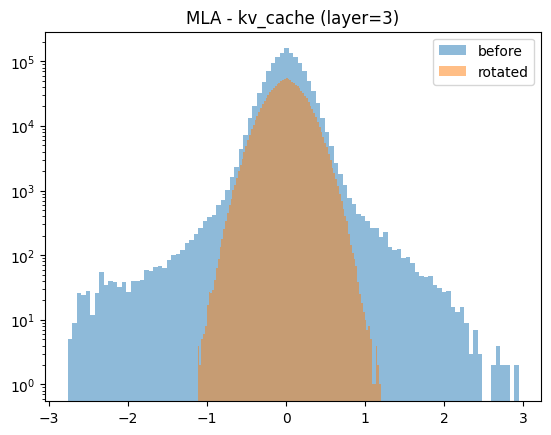

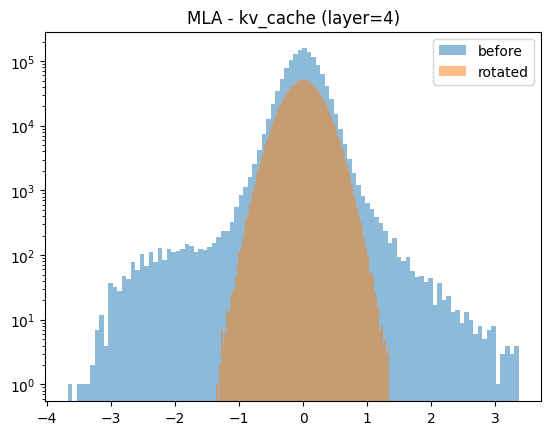

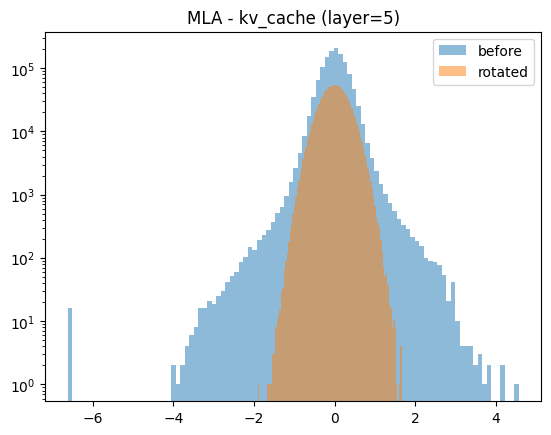

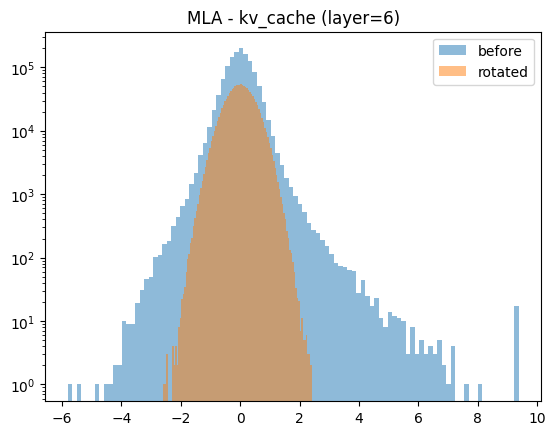

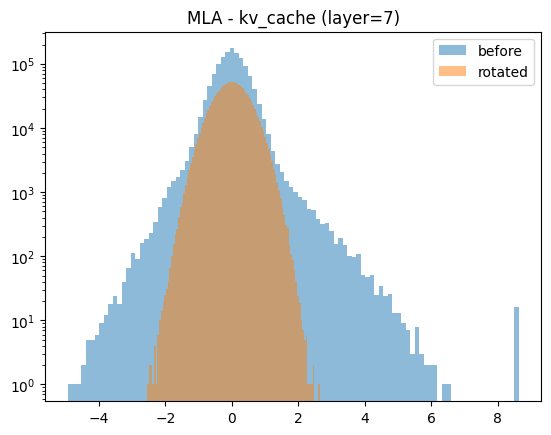

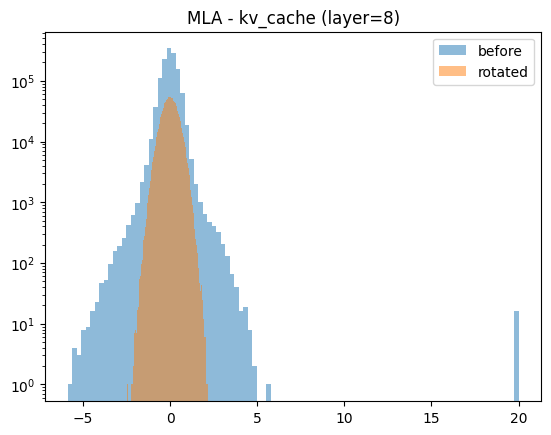

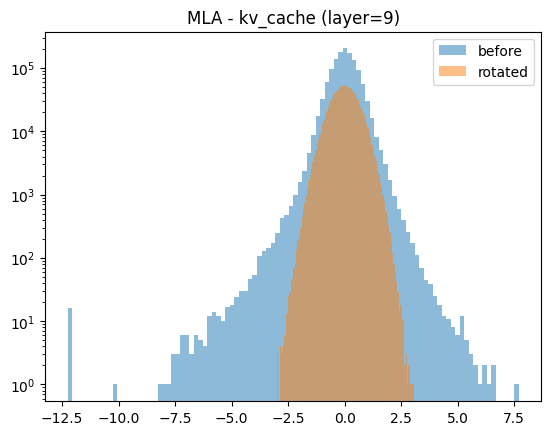

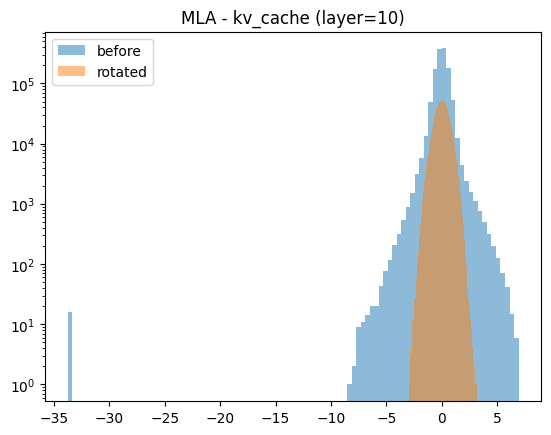

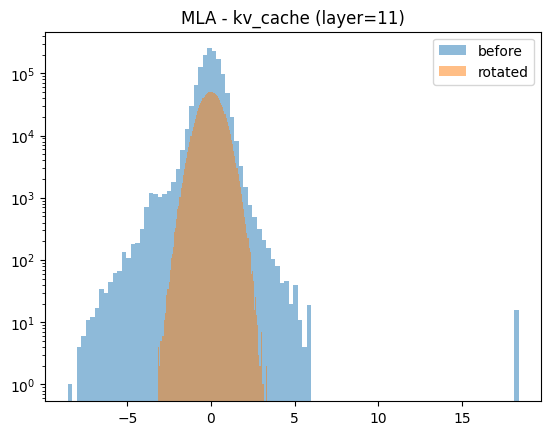

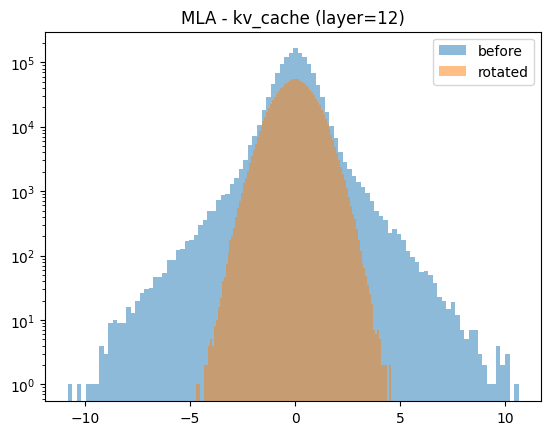

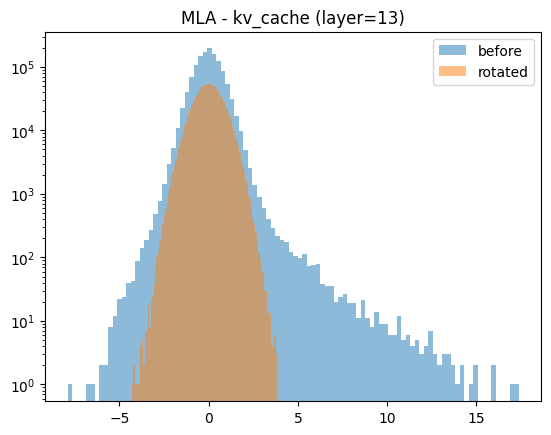

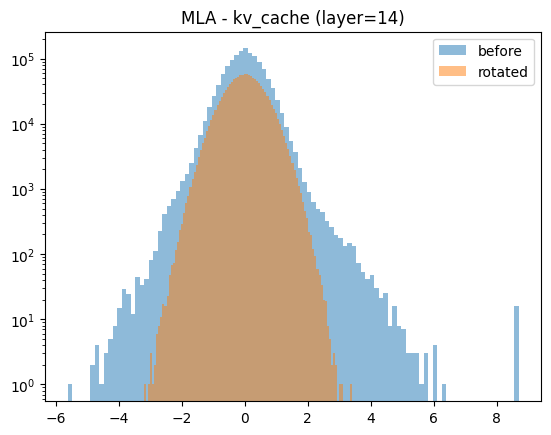

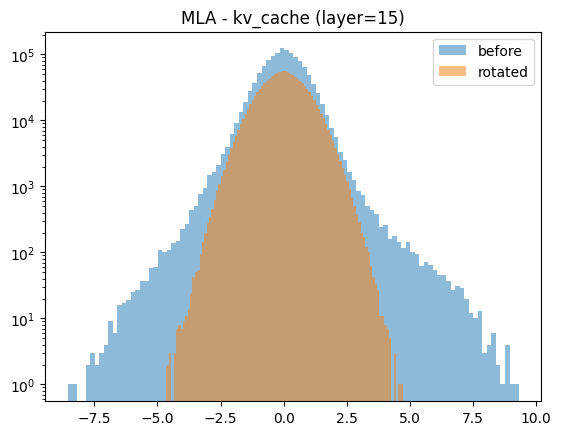

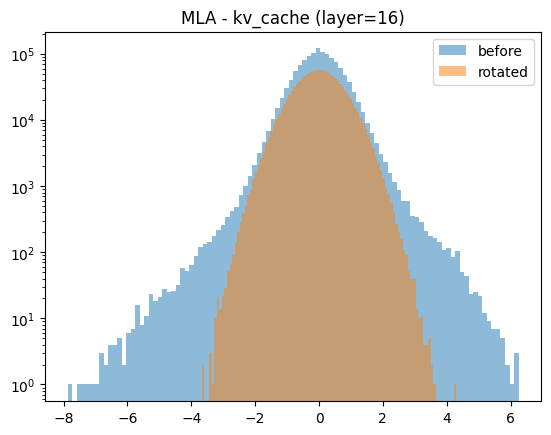

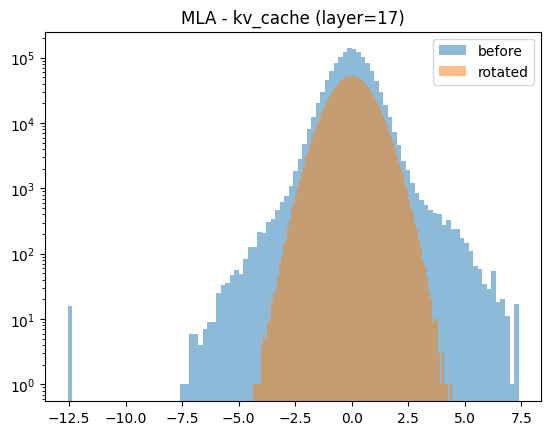

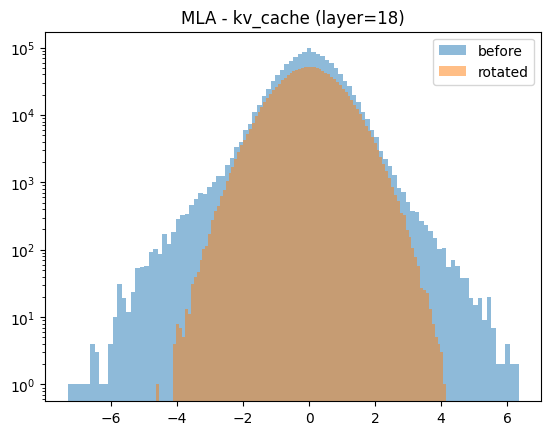

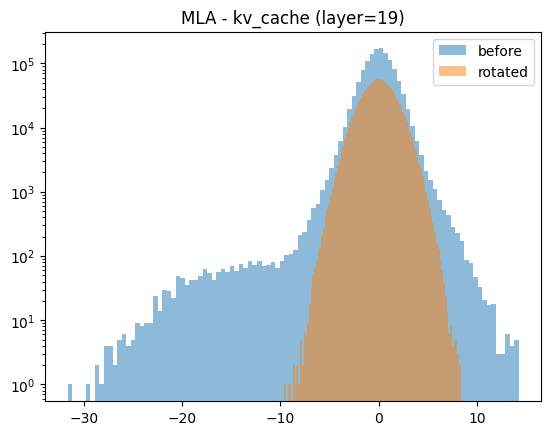

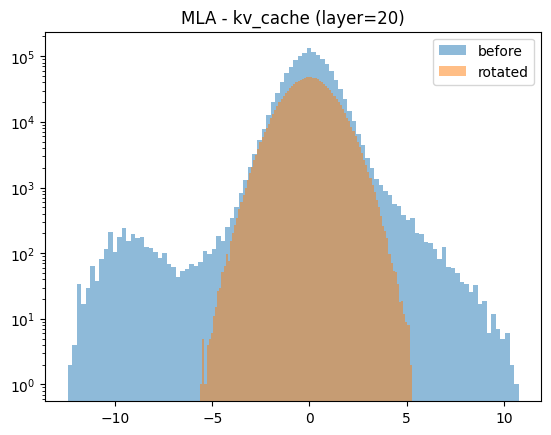

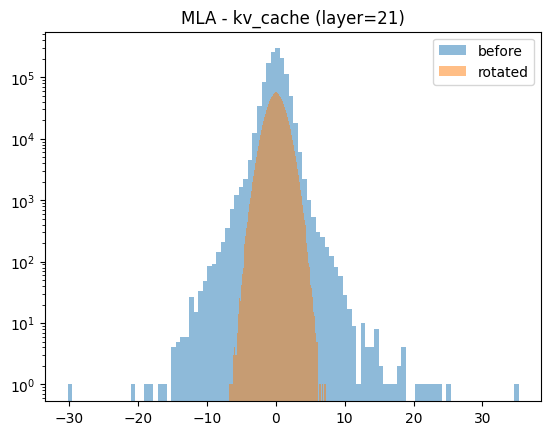

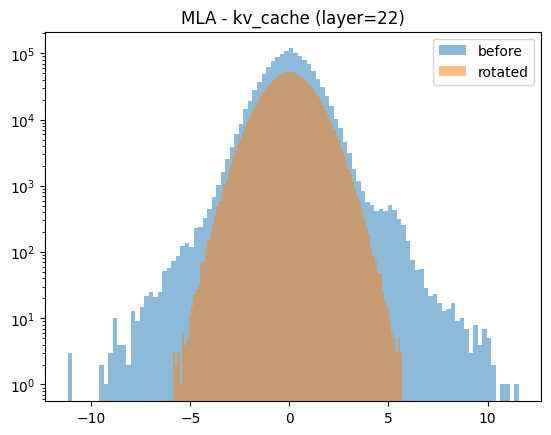

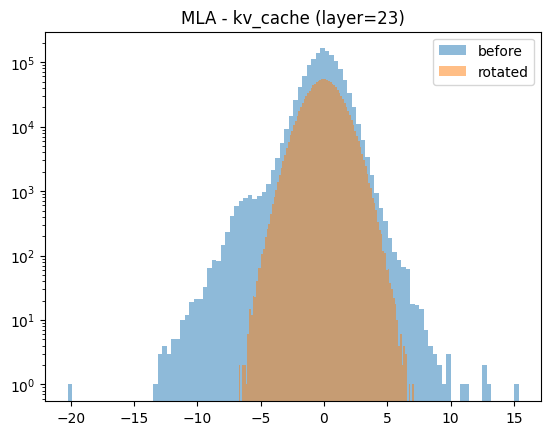

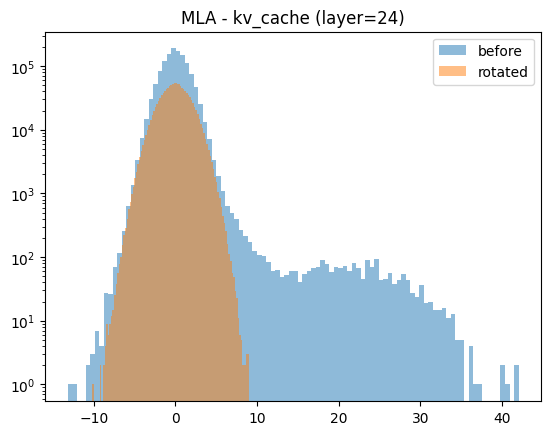

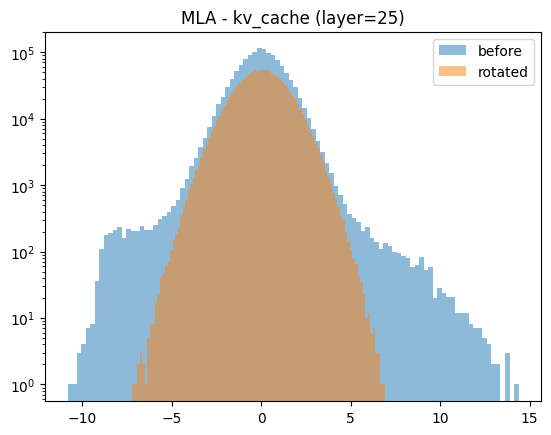

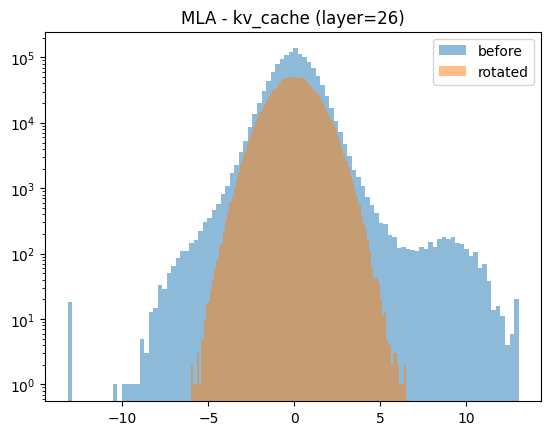

In [23]:
for layer_idx in range(27):  # 27 layers max
    plt.figure()  # one figure per layer
    plt.hist(kv_cache_all[layer_idx].flatten(), log=True, bins=100, alpha=0.5, label="before");
    plt.hist(kv_cache_all_rotate[layer_idx].flatten(), log=True, bins=100, alpha=0.5, label="rotated");
    plt.legend()
    plt.title(f"MLA - kv_cache (layer={layer_idx})")

TBD: FP16 vs INT8 GEMM precision comparison